In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymcdm.methods import TOPSIS
from pymcdm.helpers import rrankdata
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
games_df = pd.read_csv('games.csv')
plays_df = pd.read_csv('plays.csv')
scout_df = pd.read_csv('pffScoutingData.csv')
dfs = []
for i in range(1, 9):
    dfs.append(pd.read_csv(f'week{i}.csv'))
track_df = pd.concat(dfs, ignore_index=True)
del dfs

In [4]:
# Create a GroupBy object of all the game/play combinations which have a sack
sacks_gp_gb = scout_df.loc[scout_df['pff_sack'] == 1].groupby(['gameId', 'playId'])
# Create a GroupBy object of all the game/play combinations which have a hurry play with progress less than 1 yard
# First create a GroupBy object of all hurry game/play combinations
hurry_gp_gb = scout_df.loc[scout_df['pff_hurry'] == 1].groupby(['gameId', 'playId'])
# Next convert all game/play combinations in plays.csv to a Series of tuples
plays_gp_combos = plays_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)
# Finally lookup all hurry plays with a playResult less than 1 yard
hurry_lt1yd_gp_gb = plays_df.loc[(plays_gp_combos.isin(hurry_gp_gb.groups.keys())) &
                                 (plays_df['playResult'] < 1)].groupby(['gameId', 'playId'])

In [5]:
# Get all game/play combinations in the tracking data. We need this data as a Series
# because it needs to have the same number of rows so we can use it as a DataFrame
# filter with isin().
track_gp_combos = track_df[['gameId', 'playId']].parallel_apply(tuple, axis=1)

In [6]:
track_sacks_df = track_df.loc[track_gp_combos.isin(sacks_gp_gb.groups.keys())]
track_nonsacks_df = track_df.loc[~track_gp_combos.isin(sacks_gp_gb.groups.keys())]
track_hurry_df = track_df.loc[track_gp_combos.isin(hurry_lt1yd_gp_gb.groups.keys())]
track_nonhurry_df = track_df.loc[~track_gp_combos.isin(hurry_lt1yd_gp_gb.groups.keys())]

In [7]:
# Get the nflId for each pass rusher and blocker in each play of every game
pass_rush_ids_gb = scout_df.loc[scout_df['pff_role'] == 'Pass Rush'].groupby(['gameId', 'playId', 'nflId'])
pass_block_ids_gb = scout_df.loc[scout_df['pff_role'] == 'Pass Block'].groupby(['gameId', 'playId', 'nflId'])

# Sack plays

In [8]:
# Create a GroupBy object of all game/play/nflId for each sack and nonsack combination
sacks_gpn_combos = track_sacks_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)
nonsacks_gpn_combos = track_nonsacks_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)

In [9]:
sacks_avg_speed = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
sacks_avg_accel = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
sacks_sum_dist = track_sacks_df.loc[sacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
nonsacks_avg_speed = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
nonsacks_avg_accel = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
nonsacks_sum_dist = track_nonsacks_df.loc[nonsacks_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()

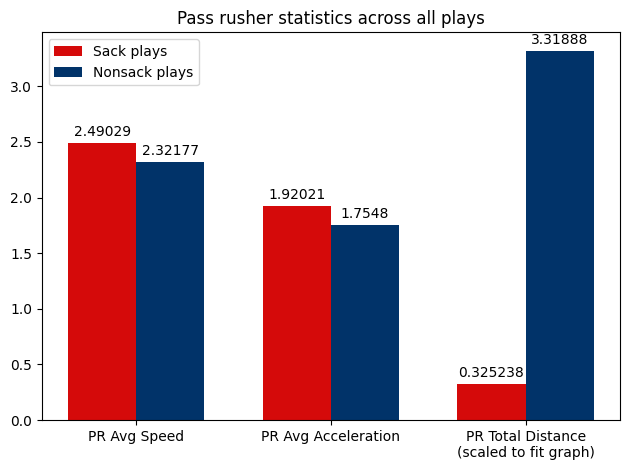

In [10]:
x_lbls = ['PR Avg Speed', 'PR Avg Acceleration', 'PR Total Distance\n(scaled to fit graph)']
x_range = np.arange(len(x_lbls))
dist_graph_scale_factor = 100000
sacks_vals = [sacks_avg_speed, sacks_avg_accel, sacks_sum_dist/dist_graph_scale_factor]
nonsacks_vals = [nonsacks_avg_speed, nonsacks_avg_accel, nonsacks_sum_dist/dist_graph_scale_factor]

bar_width = 0.35
fig, ax = plt.subplots()
bars_sacks = ax.bar(x_range - bar_width/2, sacks_vals, bar_width, label='Sack plays', color='#D50A0A')
bars_nonsacks = ax.bar(x_range + bar_width/2, nonsacks_vals, bar_width, label='Nonsack plays', color='#013369')
ax.bar_label(bars_sacks, padding=3)
ax.bar_label(bars_nonsacks, padding=3)
ax.set_xticks(x_range, x_lbls)
ax.legend()
plt.title('Pass rusher statistics across all plays')
fig.tight_layout()
plt.show()

# Hurry plays

In [11]:
hurry_gpn_combos = track_hurry_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)
nonhurry_gpn_combos = track_nonhurry_df[['gameId', 'playId', 'nflId']].parallel_apply(tuple, axis=1)

In [12]:
hurry_avg_speed = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
hurry_avg_accel = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
hurry_sum_dist = track_hurry_df.loc[hurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()
nonhurry_avg_speed = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['s'].mean()
nonhurry_avg_accel = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['a'].mean()
nonhurry_sum_dist = track_nonhurry_df.loc[nonhurry_gpn_combos.isin(pass_rush_ids_gb.groups.keys())]['dis'].sum()

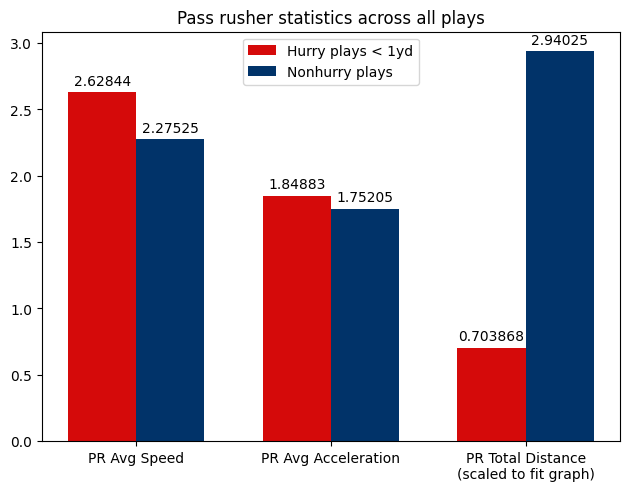

In [13]:
x_lbls = ['PR Avg Speed', 'PR Avg Acceleration', 'PR Total Distance\n(scaled to fit graph)']
x_range = np.arange(len(x_lbls))
dist_graph_scale_factor = 100000
hurry_vals = [hurry_avg_speed, hurry_avg_accel, hurry_sum_dist/dist_graph_scale_factor]
nonhurry_vals = [nonhurry_avg_speed, nonhurry_avg_accel, nonhurry_sum_dist/dist_graph_scale_factor]

bar_width = 0.35
fig, ax = plt.subplots()
bars_hurry = ax.bar(x_range - bar_width/2, hurry_vals, bar_width, label='Hurry plays < 1yd', color='#D50A0A')
bars_nonhurry = ax.bar(x_range + bar_width/2, nonhurry_vals, bar_width, label='Nonhurry plays', color='#013369')
ax.bar_label(bars_hurry, padding=3)
ax.bar_label(bars_nonhurry, padding=3)
ax.set_xticks(x_range, x_lbls)
ax.legend(loc='upper center')
fig.tight_layout()
plt.title('Pass rusher statistics across all plays')
plt.show()

# Per team metrics

In [14]:
def collect_offensive_team_metrics(r):
    gid, pid = r
    # Get an array of nflIds for the pass rushers for this play
    pass_rush_ids = scout_df.loc[(scout_df['gameId'] == gid) &
                                 (scout_df['playId'] == pid) &
                                 (scout_df['pff_role'] == 'Pass Rush')]['nflId'].to_numpy()
    # Get the team of pass rushers. This is returned as array but should only contain one team.
    pr_team = ['']
    if len(pass_rush_ids):
        pr_team = track_df.loc[(track_df['gameId'] == gid) &
                               (track_df['playId'] == pid) &
                               (track_df['nflId'] == pass_rush_ids[0])]['team'].to_numpy()
    # Get the string value of the defensive team
    defense_team = ''
    if len(pr_team):
        defense_team = np.unique(pr_team)[0]
    # Get the average speed and acceleration of the pass rushers as a Series
    pr_speed_accel_sr = track_df.loc[(track_df['gameId'] == gid) &
                                     (track_df['playId'] == pid) &
                                     (track_df['nflId'].isin(pass_rush_ids))][['s', 'a']].mean()
    # Get the total distance of the pass rushers as a Series
    pr_dist_sr = track_df.loc[(track_df['gameId'] == gid) &
                              (track_df['playId'] == pid) &
                              (track_df['nflId'].isin(pass_rush_ids))][['dis']].sum()
    #pr_dist.rename('dis')
    #pr_speed_accel['dis'] = pr_dist.values
    # Get both teams in this game to figure out which team is offense
    game_teams = games_df.loc[games_df['gameId'] == gid][['homeTeamAbbr', 'visitorTeamAbbr']].values
    offense_team = ''
    if len(game_teams):
        for gt in game_teams[0]:
            if gt != defense_team:
                offense_team = gt
    return pd.concat([pd.Series(np.unique(offense_team), index=['team']), pr_speed_accel_sr, pr_dist_sr])

gps = track_gp_combos.drop_duplicates()
offense_team_metrics_gp_df = gps.parallel_apply(collect_offensive_team_metrics)

In [15]:
offensive_team_stats = {}
for t in track_df['team'].unique():
    if t != 'football':
        avg_speed = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['s'].mean()
        avg_accel = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['a'].mean()
        sum_dist = offense_team_metrics_gp_df.loc[offense_team_metrics_gp_df['team'] == t]['dis'].sum()
        offensive_team_stats[t] = [avg_speed, avg_accel, sum_dist]


# Ranking

In [19]:
# Use TOPSIS ranking to sort the teams
topsis = TOPSIS()

team_lookup = []
stat_rank = []
for team, m in offensive_team_stats.items():
    if math.isnan(m[0]) or math.isnan(m[1]) or math.isnan(m[2]):
        continue
    team_lookup.append(team)
    stat_rank.append(np.array([m[0], m[1], m[2]]))

weights = np.array([1.0, 1.0, 1.0])
ordering = np.array([-1, -1, 1])
top_sort = TOPSIS()(np.array(stat_rank), weights, ordering)
ranking = rrankdata(top_sort)

In [17]:
order_table = {}
for i, r in enumerate(ranking):
    order_table[team_lookup[int(r)-1]] = stat_rank[i]

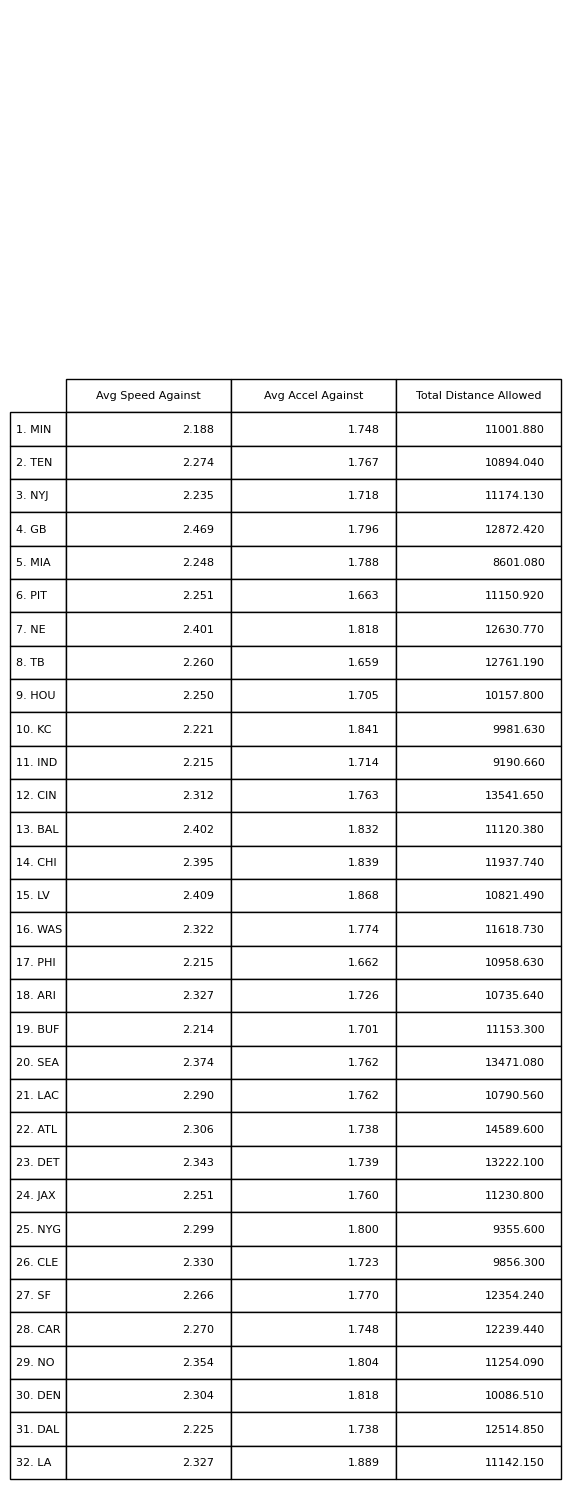

In [18]:
row_labels = []
rank = 1
for t in order_table.keys():
    row_labels.append(f'{rank}. {t}')
    rank += 1

row_cells = []
for v in order_table.values():
    cells = []
    for x in v:
        cells.append('{:.3f}'.format(x))
    row_cells.append(cells)

tbl = plt.table(np.array(row_cells),
                rowLabels=row_labels,
                colLabels=['Avg Speed Against', 'Avg Accel Against', 'Total Distance Allowed']
               )
tbl.scale(1, 2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.show()